<a href="https://colab.research.google.com/github/nico8asa/RSNA/blob/main/RSNA_2021_Deep_Learning_Lab_Pneumonia_Detection_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RSNA 2021 Deep Learning Lab

### Pneumonia Detection Model Building

#### by Ian Pan and Felipe Kitamura

### Welcome to the RSNA 2021 Deep Learning Lab! 

### In this example, we will build an *object detection* model for pneumonia detection using data from the SIIM-FISABIO-RSNA COVID-19 Detection competition hosted on Kaggle (https://www.kaggle.com/c/siim-covid19-detection).

### 1. Download data

In [1]:
!wget -q https://github.com/mdai/rsna-education-models/raw/main/sample.zip
!unzip -qq sample.zip

#### This dataset contains 1,000 images with bounding boxes from the challenge.

### 2. Installing and loading dependencies

In [2]:
# Install dependencies not included by Colab
# Use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm
!pip3 install -q imgaug
!pip3 install -q torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install -q pytorch-lightning==1.2.0
!pip3 install -q omegaconf==2.0.6
!pip3 install -q -U albumentations[imgaug]==1.1.0
!pip3 install -q timm
!pip3 install -q transformers
!pip3 install -q python-gdcm
!pip3 uninstall -q -y torchtext

     |████████████████████████████████| 2.0 MB 5.4 MB/s 
     |█████████████                   | 834.1 MB 1.6 MB/s eta 0:12:36tcmalloc: large alloc 1147494400 bytes == 0x560d3c190000 @  0x7fdb220e2615 0x560d037d54cc 0x560d038b547a 0x560d037d82ed 0x560d038c9e1d 0x560d0384be99 0x560d038469ee 0x560d037d9bda 0x560d0384bd00 0x560d038469ee 0x560d037d9bda 0x560d03848737 0x560d038cac66 0x560d03847daf 0x560d038cac66 0x560d03847daf 0x560d038cac66 0x560d03847daf 0x560d037da039 0x560d0381d409 0x560d037d8c52 0x560d0384bc25 0x560d038469ee 0x560d037d9bda 0x560d03848737 0x560d038469ee 0x560d037d9bda 0x560d03847915 0x560d037d9afa 0x560d03847c0d 0x560d038469ee
     |████████████████▌               | 1055.7 MB 1.6 MB/s eta 0:10:09tcmalloc: large alloc 1434370048 bytes == 0x560d807e6000 @  0x7fdb220e2615 0x560d037d54cc 0x560d038b547a 0x560d037d82ed 0x560d038c9e1d 0x560d0384be99 0x560d038469ee 0x560d037d9bda 0x560d0384bd00 0x560d038469ee 0x560d037d9bda 0x560d03848737 0x560d038cac66 0x560d03847daf 0x560d038

In [3]:
import ast
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, os.path as osp
import pandas as pd
import pickle
import re
import torch

from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

### 3. Reformat the annotations

In [4]:
df = pd.read_csv('/content/sample/sample_annotations.csv')
df['boxes'] = df.boxes.apply(ast.literal_eval)
df.head()

,id,boxes,label,StudyInstanceUID,SOPInstanceUID,filename
0,0049814626c8_image,"[{'x': 63.72400149137931, 'y': 100.21893761206...",opacity 1 529.25901 832.36731 1002.80649999999...,4d7a2748dfb1,0049814626c8,4d7a2748dfb1-49f74cf4cbad-0049814626c8.jpeg
1,004cbd797cd1_image,"[{'x': 88.18959320628552, 'y': 200.29186482113...",opacity 1 515.18569 1170.06439 1378.5248700000...,30e45593ba08,004cbd797cd1,30e45593ba08-c5c0a57e6e4c-004cbd797cd1.jpeg
2,008ca392cff3_image,"[{'x': 275.6763027586207, 'y': 162.04381827586...",opacity 1 2284.17508 1342.64878 3307.2952 2708...,39a80a14bfda,008ca392cff3,39a80a14bfda-088a20979e31-008ca392cff3.jpeg
3,008ff73b4ef3_image,"[{'x': 73.36180458715597, 'y': 89.401637098623...",opacity 1 609.25232 742.45931 1762.01025 2478....,2c7d0327a977,008ff73b4ef3,2c7d0327a977-1c5d4ad5fe67-008ff73b4ef3.jpeg
4,00a129830f4e_image,"[{'x': 89.64573278253425, 'y': 212.41513978595...",opacity 1 496.23799 1175.83357 1113.61823 1840...,3a3c198051f0,00a129830f4e,3a3c198051f0-e38a48e1f5ab-00a129830f4e.jpeg


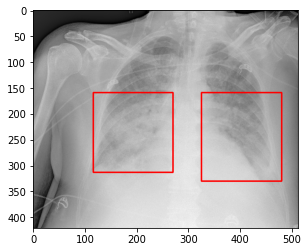

In [7]:
def draw_bbox(img, rects):
    for r in rects:
        xmin, ymin = int(r['x']), int(r['y'])
        xmax, ymax = xmin+int(r['width']), ymin+int(r['height'])
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    return img

# Display random image
example = df.iloc[np.random.randint(len(df))]
img = cv2.imread(osp.join('/content/sample/images', example.filename))
img = draw_bbox(img, example.boxes)
plt.imshow(img, cmap='gray'); plt.show()

In [8]:
def get_bboxes(box_list):
    boxes = []
    for box in box_list:
        boxes.append(np.expand_dims(np.array([box['x'], box['y'], box['width'], box['height']]), axis=0))
    boxes = np.concatenate(boxes)
    boxes[:,2] += boxes[:,0] ; boxes[:,3] += boxes[:,1]
    return boxes
  

# Split data into train (70%), val (10%), test (20%)
train_frac, val_frac, test_frac = 0.7, 0.1, 0.2
assert train_frac + val_frac + test_frac == 1
np.random.seed(42)
df['outer'] = -1
test_rows = np.random.choice(range(len(df)), int(len(df) * test_frac), replace=False)
df.loc[test_rows, 'outer'] = 0 
df['inner0'] = -1 
non_test_rows = list(set(range(len(df))) - set(test_rows))
val_rows = np.random.choice(non_test_rows, int(len(df) * val_frac), replace=False)
df.loc[val_rows, 'inner0'] = 0

annotations = []
for i in tqdm(range(len(df)), total=len(df)):
    ann = dict(filename=df.filename.iloc[i])
    img = Image.open(osp.join('/content/sample/images', ann['filename']))
    ann['img_width'], ann['img_height'] = img.size
    box_list = df.boxes.iloc[i]
    bboxes = get_bboxes(box_list)
    bboxes[:,[0,2]] = np.clip(bboxes[:,[0,2]], 0, ann['img_width'])
    bboxes[:,[1,3]] = np.clip(bboxes[:,[1,3]], 0, ann['img_height'])
    ann['bbox'] = bboxes
    ann['cls'] = np.ones((bboxes.shape[0],)).astype('int')
    ann['folds'] = dict(outer=df.outer.iloc[i])
    for column in df.columns:
        if 'inner' in column:
            ann['folds'].update({column : df[column].iloc[i]})
    annotations += [ann]


with open('/content/sample/bbox_annotations.pkl', 'wb') as f:
    pickle.dump(annotations, f)


annotations[0]


100%|██████████| 1000/1000 [00:01<00:00, 529.44it/s]


{'bbox': array([[ 63.72400149, 100.21893761, 120.7402079 , 304.24755615],
        [365.01554515, 133.19888755, 444.39108455, 322.13496234]]),
 'cls': array([1, 1]),
 'filename': '4d7a2748dfb1-49f74cf4cbad-0049814626c8.jpeg',
 'folds': {'inner0': -1, 'outer': -1},
 'img_height': 419,
 'img_width': 512}

### 4. Download pneumonia detection library from GitHub

In [9]:
!rm -rf siim_covid19_detection
!git clone https://github.com/i-pan/siim_covid19_detection
os.chdir('/content/siim_covid19_detection/ian-siim/detect/')
!wget -q https://github.com/mdai/rsna-education-models/raw/main/rsna18_effb0_256_pretrained_opacity.ckpt

Cloning into 'siim_covid19_detection'...
remote: Enumerating objects: 2390, done.
remote: Counting objects: 100% (2390/2390), done.
remote: Compressing objects: 100% (1631/1631), done.
remote: Total 2390 (delta 720), reused 2380 (delta 714), pack-reused 0
Receiving objects: 100% (2390/2390), 14.83 MiB | 8.83 MiB/s, done.
Resolving deltas: 100% (720/720), done.


#### We have also downloaded an object detection model pretrained on the RSNA 2018 Pneumonia Detection challenge to get a "head start" in model training.


#### This is an EfficientDet-D0 model trained on 256 x 256 pixel images.

### 5. Prepare configuration file for training

In [10]:
cfg = OmegaConf.load('configs/mks/mk_fast.yaml')
cfg.data.annotations = '/content/sample/bbox_annotations.pkl'
cfg.data.data_dir = '/content/sample/images'
cfg.data.dataset.name = 'CXRDataset'
cfg.data.dataset.params.dicom = False
cfg.data.outer_fold = 0
cfg.data.inner_fold = 0

cfg.transform.resize.params.imsize = [256, 256]
cfg.transform.augment.name = 'grayscale_augment'
cfg.transform.augment.p = 0.9 # Probability of applying augmentation to a given image
cfg.transform.augment.n = 3 # Strength of augmentation (process where you perform a transformation of the image)

cfg.model.params.base = 'tf_efficientdet_d0'
cfg.model.params.backbone = 'tf_efficientnet_b0'
cfg.model.params.num_classes = 1
cfg.model.params.pretrained = False # Don't need ImageNet pretrained weights
cfg.model.params.image_size = cfg.transform.resize.params.imsize
cfg.model.load_pretrained = 'rsna18_effb0_256_pretrained_opacity.ckpt'

cfg.scheduler.name = 'CustomOneCycleLR'
cfg.optimizer.params.lr = 5.0e-6
cfg.scheduler.params.max_lr = 5.0e-4
cfg.train.num_epochs = 5  #number of time you go trough the trainig set
cfg.train.batch_size = 8 #how many images I have in my batch

OmegaConf.save(config=cfg, f='configs/mks/mk_fast.yaml')

### 6. Run training loop

In [11]:
!python main.py train configs/mks/mk_fast.yaml --gpus 1 --precision 16 --num-workers 2

PyTorch environment ...
  torch.__version__              = 1.9.0+cu111
  torch.version.cuda             = 11.1
  torch.backends.cudnn.version() = 8005


Running experiment mk_fast ...
Saving checkpoints and logs to ../experiments/detect/ ...
Global seed set to 88
<inner fold> : 0
<outer fold> : 0
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
TRAIN : n=700
VALID : n=100
Creating model <EffDet> ...
 

### 7. Evaluate the results

In [12]:
import sys ; sys.path.insert(0, '/content/siim_covid19_detection/ian-siim/')

from detect.skp import builder
from detect.skp.controls.datamaker import get_train_val_test_splits
from detect.skp.metrics import mAP
from detect.skp.task_utils import tpfp_default


def get_tpfp(dets, gt_bboxes, gt_labels):
    nc = 1
    tpfp_list, num_gts = [], []
    for each_cls in range(1, nc+1): 
        classes = dets[...,-1]
        cls_dets = dets[classes == each_cls]
        cls_gt = gt_labels[gt_labels == each_cls]
        cls_bboxes = gt_bboxes[gt_labels == each_cls]
        tp, fp = tpfp_default(cls_dets[...,:-1], cls_bboxes, iou_thr=0.5)
        scores = cls_dets[...,-2]
        results = torch.cat([tp, fp, scores.unsqueeze(0)])
        results = results.transpose(1,0)
        tpfp_list.append(results)
        num_gts.append(len(cls_gt))
    return tpfp_list, num_gts
  

def load_model(cfg, checkpoint):
    cfg.model.params.pretrained = False
    cfg.model.params.inference = True
    if 'load_pretrained' in cfg.model.params: cfg.model.params.load_pretrained = None
    model = builder.build_model(cfg)
    print (f'Loading model from {checkpoint} ... ')
    weights = torch.load(checkpoint, map_location=lambda storage, loc: storage)['state_dict']
    weights = {re.sub(r'^model.', '', k) : v for k,v in weights.items()}
    model.load_state_dict(weights)
    return model.eval().cuda()


def load_config(cfgname):
    config = OmegaConf.load(f'configs/mks/{cfgname}.yaml')
    config.data.dataset.name = 'CXRDataset'
    config.data.dataset.params.dicom = True
    return config


def draw_bbox(img, rects):
    for r in rects:
        xmin, ymin, xmax, ymax = r
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    return img


cfg = load_config('mk_fast')
model = load_model(cfg, '../experiments/detect/mk_fast/checkpoints/last.ckpt')
dataset = builder.build_dataset(cfg, data_info=dict(annotations=[]), mode='predict')
with open('/content/sample/bbox_annotations.pkl', 'rb') as f:
    ann = pickle.load(f)

_,val_ann,test_ann = get_train_val_test_splits(cfg, ann)

# Store detection predictions
model_predictions = {}
visualizations = []
metric = mAP(num_classes=1)

for a in tqdm(test_ann):
    img = cv2.imread(osp.join('/content/sample/images', a['filename']))
    original_size = img.shape
    gt_bboxes = torch.from_numpy(a['bbox'])
    gt_labels = torch.from_numpy(a['cls'])

    X = dataset.resize(image=img.copy(), bboxes=[], labels=[])['image']
    new_size = X.shape
    scale_factor = (original_size[0] / new_size[0], original_size[1] / new_size[1])
    X = dataset.preprocess(X)
    X = X.transpose(2,0,1)
    X = torch.from_numpy(X).float().unsqueeze(0).cuda()
    with torch.no_grad():
        dets = model(X)
    dets = dets[0, :, [1,0,3,2,4,5]]
    dets[:, [0,2]] *= scale_factor[1]
    dets[:, [1,3]] *= scale_factor[0]

    results = [get_tpfp(dets, gt_bboxes, gt_labels)]
    # Reformat results so that it is a list of length=num_classes
    # Then turn each element of this list into a torch.Tensor
    results_reformat, num_gts = [], []
    for each_cls in range(1):
        class_list = [r[0][each_cls] for r in results]
        cls_num_gts = sum([r[1][each_cls] for r in results])
        results_reformat.append(torch.cat(class_list))
        num_gts.append(cls_num_gts)
    
    metric.update(results_reformat, num_gts)
    dets = dets.cpu().numpy()
    img_w_bbox = draw_bbox(img.copy(), list(dets[dets[:,4] >= 0.3, :4].astype('int')))
    model_predictions[a['filename']] = dets
    visualizations.append(img_w_bbox)

final_map = metric.compute()['map']
print(f'\n\nMEAN AVERAGE PRECISION: {final_map:0.4f}')

Creating model <EffDet> ...
  Using backbone <tf_efficientnet_b0> ...
  Pretrained : False
Loading model from ../experiments/detect/mk_fast/checkpoints/last.ckpt ... 
<inner fold> : 0
<outer fold> : 0


100%|██████████| 200/200 [00:14<00:00, 13.61it/s]



MEAN AVERAGE PRECISION: 0.3962


## How well did your AI model perform?

For initial evaluation of your AI model, we're using a metric called mean average precision (final number in above cell).

### mAP

Mean average precision (mAP) is a popular metric for evaluating the performance of object detection models which predict bounding boxes. First, an overlap threshold is specified to determine whether a predicted bounding box is a true positive. The mAP takes into account the model's sensitivity and positive predictive value at the bounding box level. The theoretical range of mAP is 0 to 1. For this task, mAP of 0.6 is considered very good.

Here's a good reference for additional information about mAP: https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52#1a59

### Let's look at a few examples of how well your AI model predicts pneumonia below for a few random images.

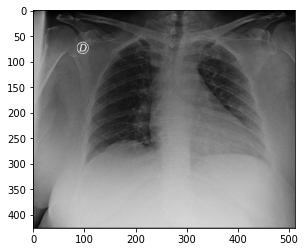

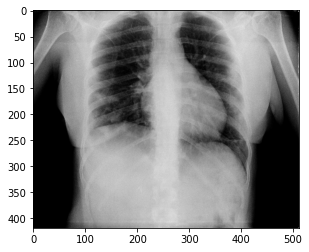

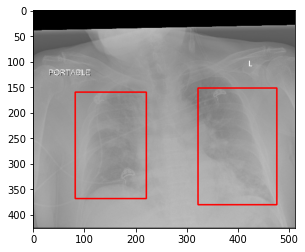

In [13]:
# Finally, let's look at some of the AI outputs that your model predicts on the test data
#
# Each time you press the play button on the left, a few random images with predicted
# bounding boxes will be shown. 
plt.imshow(np.random.choice(visualizations)); plt.show()
plt.imshow(np.random.choice(visualizations)); plt.show()
plt.imshow(np.random.choice(visualizations)); plt.show()